In [36]:
from kubernetes import client, config
import pandas as pd
import matplotlib.pyplot as plt

from prometheus_api_client import PrometheusConnect

from datetime import datetime, timedelta
from difflib import diff_bytes
import matplotlib.pyplot as plt

In [37]:
# Kubernetes Config
config.load_kube_config()
v1 = client.CoreV1Api()

# Prometheus Config
#prom_url = "http://<PROMETHEUS_SERVER_IP>:<PORT>"
# prom_url = "http://10.110.188.57:9090"
prom_url = "http://10.105.116.175:9090"

prom = PrometheusConnect(url=prom_url, disable_ssl=True)
#test prom connection
prom_connect_response = prom.custom_query(query="up")
print(prom_connect_response)

[{'metric': {'__name__': 'up', 'app': 'compose-post-service', 'instance': '192.168.18.199:15020', 'job': 'kubernetes-pods', 'namespace': 'social-network', 'pod': 'compose-post-service-866f6d7b74-45swb', 'pod_template_hash': '866f6d7b74', 'security_istio_io_tlsMode': 'istio', 'service': 'compose-post-service', 'service_istio_io_canonical_name': 'compose-post-service', 'service_istio_io_canonical_revision': 'latest'}, 'value': [1713362427.999, '1']}, {'metric': {'__name__': 'up', 'app': 'details', 'instance': '192.168.231.244:15020', 'job': 'kubernetes-pods', 'namespace': 'default', 'pod': 'details-v1-6cccc87c79-gwpkf', 'pod_template_hash': '6cccc87c79', 'security_istio_io_tlsMode': 'istio', 'service_istio_io_canonical_name': 'details', 'service_istio_io_canonical_revision': 'v1', 'version': 'v1'}, 'value': [1713362427.999, '1']}, {'metric': {'__name__': 'up', 'app': 'home-timeline-redis', 'instance': '192.168.5.47:15020', 'job': 'kubernetes-pods', 'namespace': 'social-network', 'pod': '

In [38]:
from datetime import datetime, timedelta

def transmitted_req_calculator(workload_src, workload_dst, timerange, step_interval):
    # Define the end time as now
    end_time = datetime.now() - timedelta(minutes=0)
    # Define the start time as 'timerange' minutes before the end time
    start_time = end_time - timedelta(minutes=timerange)

    # Define the istio request query
    istio_req_query = f'istio_requests_total{{reporter="source",source_workload="{workload_src}",destination_workload="{workload_dst}",response_code="200"}}'
    
    # Fetch the data from Prometheus
    istio_response = prom.custom_query_range(
        query=istio_req_query,
        start_time=start_time,
        end_time=end_time,
        step=step_interval  # 300s = 5 minutes
    )
    
    
    if not istio_response or not istio_response[0]['values']: # the response is empty or the response values field is empty
        # print("No values found in the query")
        return 0  # In case no data is returned, means no transmitted requests, set to 0
    else:
        #if not istio_response is not empty, then continue the caculation
        values = istio_response[0]['values'] # values are value_pair, and value_pair is [timestamp, value]
                
        # Extract beginning and end value pairs
        begin_timestamp, begin_req_counter = values[0]
        end_timestamp,end_req_counter = values[-1]
        
        data_points_num = len(values)
        average_requests = (int(end_req_counter)-int(begin_req_counter))/data_points_num

        return average_requests

# Example usage, the average usage should be the (end_value_counter - begin_value_couter)/total_time_points
average_requests = transmitted_req_calculator(workload_src="productpage-v1", workload_dst="reviews-v1", timerange=120, step_interval='5m') # quering time length, timerange in Minutes
print(f"Average requests per 5 minutes: {average_requests}")


Average requests per 5 minutes: 3.7142857142857144


In [39]:

average_requests = transmitted_req_calculator(workload_src="productpage-v1", workload_dst="reviews-v2",  timerange=120, step_interval='5m') # quering time length, timerange in Minutes
print(f"Average requests per 5 minutes: {average_requests}")

Average requests per 5 minutes: 0.47619047619047616


In [40]:
# Configure API client
# config.load_kube_config()  # This loads your current kube config
# Initialize the Kubernetes client
# v1 = client.AppsV1Api()
namespace = 'default'  # Specify the namespace
def get_ready_deployments(namespace):
    ready_deployments = []
    # List deployments in the specified namespace
    deployments = client.AppsV1Api().list_namespaced_deployment(namespace)
    for deployment in deployments.items:
        # Check if the deployment is ready
        # "ready replicas" equals "replicas" indicates deployment is ready
        if deployment.status.ready_replicas == deployment.spec.replicas:
            ready_deployments.append(deployment.metadata.name)
    
    return ready_deployments

# Retrieve and print the list of ready deployments
ready_deployments = get_ready_deployments(namespace)
print("Ready Deployments:", ready_deployments)


Ready Deployments: ['details-v1', 'example-deployment', 'productpage-v1', 'ratings-v1', 'reviews-v1', 'reviews-v2', 'reviews-v3']


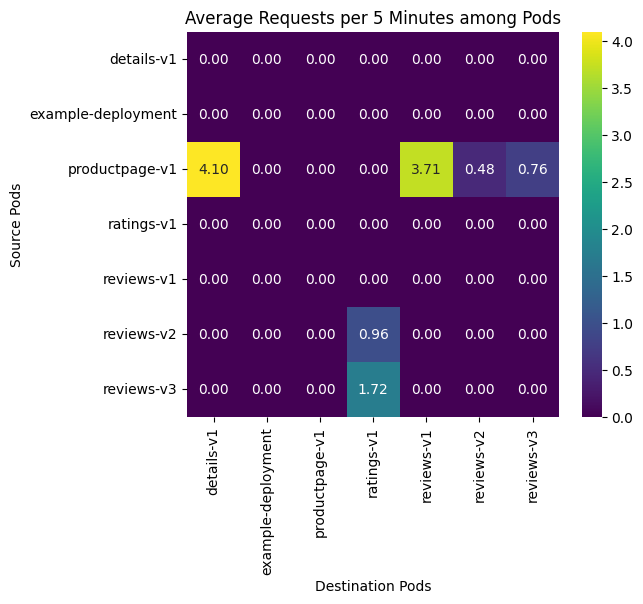

In [41]:
import seaborn as sns

# Initialize an empty DataFrame
df = pd.DataFrame(index=ready_deployments, columns=ready_deployments, data=0.0)

for deployment_src in ready_deployments:
    for deployment_dst in ready_deployments:
        if deployment_src != deployment_dst:  # Skip self to self comparison
            average_requests = transmitted_req_calculator(workload_src=deployment_src, workload_dst=deployment_dst, timerange=120, step_interval='5m')
            df.at[deployment_src, deployment_dst] = average_requests

# Since the data might not represent a traditional correlation, directly plotting it
plt.figure(figsize=(6, 5))
sns.heatmap(df, annot=True, cmap='viridis', fmt=".2f")
plt.title('Average Requests per 5 Minutes among Pods')
plt.xlabel('Destination Pods')
plt.ylabel('Source Pods')
plt.show()
        
    

In [16]:
#Updated: 11 April, 2024
#define Chain Element (upStream_Microservice, downStrem_Microservice, stress)
from collections import defaultdict

class ChainElement:  # CE <UM, DM Stress>
    def __init__(self, upStream_MS, downStream_MS, stress):
        # define three attributes of for each ChainElement
        self.upStream_MS = upStream_MS
        self.downStream_MS = downStream_MS
        self.stress = stress
    
    def __repr__(self):
        return f"<{self.upStream_MS}, {self.downStream_MS}, {self.stress}>"

# define the ChainPath
class ChainPathAnalysis:
    def __init__(self, chain_elements):
        self.chain_elements = chain_elements
        self.chain_graph = defaultdict(list)
        self._build_stress_graph()

    def _build_stress_graph(self):
        for chain in self.chain_elements:
            self.chain_graph[chain.upStream_MS].append((chain.downStream_MS, chain.stress)) # building the path by appending dependent microservices(UM->DM)
    '''
    build example:
    # Create some chain elements
            chain_elements = [
                ChainElement('MS1', 'MS2', 10),
                ChainElement('MS1', 'MS3', 20),
                ChainElement('MS2', 'MS4', 30),
            ]
            # Create a ChainPathAnalysis instance
            analysis = ChainPathAnalysis(chain_elements)
            # analysis.chain_graph is a defaultdict and it looks like this, which shows one UM could have mutiple DM:
            # MS1->MS2 (with stress 10), MS1->MS3 (with stress 20), MS2->MS4 (with stress 30)
            # {'MS1': [('MS2', 10), ('MS3', 20)], 'MS2': [('MS4', 30)]}
    '''

    def _find_all_ChainPaths(self, start_MS, end_MS, path=[], stress_sum=0, count=0): # 'ms' is abbration for microservice
        path = path + [start_MS] # a single path
        if start_MS == end_MS:
            # return [(path, stress_sum/count if count > 0 else 0)]
            if count > 0:
                average_stress = stress_sum / count
            else:
                average_stress = 0
            return [(path, average_stress)]
        
        if start_MS not in self.chain_graph:
            return []
        paths = [] # store all found paths
        for new_MS, stress in self.chain_graph[start_MS]: 
            if new_MS not in path: # new_MS is not included in the path
                newpaths = self._find_all_ChainPaths(new_MS, end_MS, path, stress_sum + stress, count + 1)
                for newpath in newpaths:
                    paths.append(newpath) # add the found new paths
        return paths

    # find the longest path in current networking environment
    # sort chain paths based on each path's stress
    def sort_chain_paths(self): 
        start_MSs = set(self.chain_graph.keys())
        end_MSs = set([chain.downStream_MS for chain in self.chain_elements]) - start_MSs

        all_paths = []
        for start_MS in start_MSs:
            for end_MS in end_MSs:
                all_paths.extend(self._find_all_ChainPaths(start_MS, end_MS))

        # Sort all chain paths by path's average stress
        sorted_chain_paths = sorted(all_paths, key=lambda x: x[1], reverse=True)
        return sorted_chain_paths

    def __repr__(self):
        return f"ChainPath Analysis with {len(self.chain_elements)} element chains"

In [28]:
df = pd.DataFrame(index=ready_deployments, columns=ready_deployments, data=0.0)
element_chains=[] # initail element_chains are empty, <upStream_pod, downStream_pod, transmit_frequency>
for deployment_src in ready_deployments:
    for deployment_dst in ready_deployments:
        if deployment_src != deployment_dst:  # Skip self to self comparison
            average_requests = transmitted_req_calculator(workload_src=deployment_src, workload_dst=deployment_dst, timerange=120, step_interval='5m')
            #find chain elements
            if 0<average_requests: # select the elementChain with real transmition
                element_chains.append(ChainElement(deployment_src, deployment_dst,average_requests))
            df.at[deployment_src, deployment_dst] = average_requests

element_chains

[<productpage-v1, details-v1, 36.88>,
 <productpage-v1, reviews-v1, 31.4>,
 <productpage-v1, reviews-v2, 4.12>,
 <productpage-v1, reviews-v3, 7.64>,
 <reviews-v2, ratings-v1, 4.0>,
 <reviews-v3, ratings-v1, 7.4>]

In [30]:
# Analyze critical chains
analysis = ChainPathAnalysis(element_chains)
sorted_chain_paths = analysis.sort_chain_paths()

# Display the longest critical path(s) and their average frequency (with sorting)
print("Critical Path(s):")
for path, avg_stress in sorted_chain_paths:
    print(f"Path: {'->'.join(path)}, Average Stress (Reqs frequency): {avg_stress}")

Critical Path(s):
Path: productpage-v1->details-v1, Average Stress (Reqs frequency): 36.88
Path: productpage-v1->reviews-v1, Average Stress (Reqs frequency): 31.4
Path: productpage-v1->reviews-v3->ratings-v1, Average Stress (Reqs frequency): 7.52
Path: reviews-v3->ratings-v1, Average Stress (Reqs frequency): 7.4
Path: productpage-v1->reviews-v2->ratings-v1, Average Stress (Reqs frequency): 4.0600000000000005
Path: reviews-v2->ratings-v1, Average Stress (Reqs frequency): 4.0


In [ ]:
#check the pod workloads in critical paths are in the same node or (at the node with minimal communication delay)



In [1]:
# kubectl patch reviews-1, review-2 and review-3 pod to the node that productpage pod runns on:
from kubernetes import client, config
import time

# Load the kube config from the default location
config.load_kube_config()

# API instances
apps_v1_api = client.AppsV1Api()
core_v1_api = client.CoreV1Api()

def patch_deployment(deployment_name, namespace, new_node_name):
    """Patch the deployment to use a specific node."""
    body = {
        "spec": {
            "template": {
                "spec": {
                    "nodeSelector": {
                        "kubernetes.io/hostname": new_node_name
                    }
                }
            }
        }
    }
    try:
        apps_v1_api.patch_namespaced_deployment(name=deployment_name, namespace=namespace, body=body)
        print(f"Deployment '{deployment_name}' patched to schedule pods on '{new_node_name}'.")
    except Exception as e:
        print(f"Failed to patch the deployment: {e}")
        return False
    return True

def wait_for_rolling_update_to_complete(deployment_name, namespace, new_node_name):
    """Wait for the rolling update to complete."""
    print("Waiting for the rolling update to complete...")
    while True:
        pods = core_v1_api.list_namespaced_pod(namespace=namespace, label_selector=f'app={deployment_name}').items
        all_pods_updated = all(pod.spec.node_name == new_node_name and
                               pod.status.phase == 'Running'
                               for pod in pods)
        print("all_pods_updated=",all_pods_updated)
        print("len(pods)=", len(pods))
        if all_pods_updated and len(pods) >= 0:
            print("All pods are running on the new node.")
            break
        else:
            print("Rolling update in progress...")
            time.sleep(5)



# Define the patch variables 
namespace = 'default'  # 
deployment_name = 'example-deployment'
new_node_name = 'k8s-worker-6'  # Target node for the new pods

if patch_deployment(deployment_name, namespace, new_node_name):
    wait_for_rolling_update_to_complete(deployment_name, namespace, new_node_name)


Deployment 'example-deployment' patched to schedule pods on 'k8s-worker-6'.
Waiting for the rolling update to complete...
all_pods_updated= True
len(pods)= 0
All pods are running on the new node.


In [ ]:
# pod_ critical path analysis (pod correlations)

In [ ]:
# node ranking algo:

#def node_ranking 



In [60]:
patch_deployment(deployment_name='reviews-v1', namespace='default', new_node_name='k8s-worker-2')

Deployment 'reviews-v1' patched to schedule pods on 'k8s-worker-2'.


True

In [61]:
patch_deployment(deployment_name='reviews-v2', namespace='default', new_node_name='k8s-worker-2')

Deployment 'reviews-v2' patched to schedule pods on 'k8s-worker-2'.


True

In [62]:
patch_deployment(deployment_name='reviews-v3', namespace='default', new_node_name='k8s-worker-2')

Deployment 'reviews-v3' patched to schedule pods on 'k8s-worker-2'.


True